In [312]:
%pylab inline
import IPython
from IPython.display import Audio
import librosa
import librosa.display
from tqdm.notebook import tqdm
import torch
import random
import torch.functional as F

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/user/My Document/Tacotron_Exp/.taco_env/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['text', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [20]:
from ttslearn.pretrained import create_tts_engine

pwg_engine = create_tts_engine("tacotron2_hifipwg_jsut24k", device="mps")

wav, sr = pwg_engine.tts("goppd morning akiya tie")
IPython.display.display(Audio(wav, rate=sr))

CPU times: user 5.41 s, sys: 246 ms, total: 5.66 s
Wall time: 5.23 s


In [23]:
pwg_engine = create_tts_engine("multspk_tacotron2_hifipwg_jvs24k", device="mps")
for spk in ["jvs001", "jvs010", "jvs030", "jvs050", "jvs100"]:
    text = "ピーナッツ！！" + ("寿司" if random.random() > 0.2 else "タコス") + "が好きです。"
    wav, sr = pwg_engine.tts(text, spk_id=pwg_engine.spk2id[spk])
    print(f"Speaker: {spk}")
    print(text)
    IPython.display.display(Audio(wav, rate=sr))

Speaker: jvs001
ピーナッツ！！寿司が好きです。


Speaker: jvs010
ピーナッツ！！寿司が好きです。


Speaker: jvs030
ピーナッツ！！寿司が好きです。


Speaker: jvs050
ピーナッツ！！寿司が好きです。


Speaker: jvs100
ピーナッツ！！寿司が好きです。


-----

-----

## Pytorch 基礎

In [227]:
import numpy as np
import torch 
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [25]:
#0次元テンソル
x0 = torch.tensor(1)
print(x0.shape, x0)

torch.Size([]) tensor(1)


In [31]:
# 連続データ
x = torch.arange(5)
print(x)
x = torch.arange(1,5)
print(x)
x = torch.arange(1, 10, 2)
print(x)


tensor([0, 1, 2, 3, 4])
tensor([1, 2, 3, 4])
tensor([1, 3, 5, 7, 9])


In [39]:
# ランダムデータ
#一様分布
x = torch.rand(2, 2)
print(x)
# 標準正規分布
x = torch.randn(3, 3)
print(x)
# 正規分布 ( 平均、 標準偏差を入力する. sizeで次元指定) 
x = torch.normal(5, 1, size=(6,))
print(x)

tensor([[0.8053, 0.8367],
        [0.3307, 0.9885]])
tensor([[-0.6933, -0.1668, -0.9999],
        [-1.6476,  0.8098,  0.0554],
        [ 1.1340, -0.5326,  0.6592]])
tensor([3.4036, 4.6231, 1.8980, 4.9005, 4.2787, 6.2708])


In [46]:
#データの変形 (次元分割、統合)
x = torch.randn(6)
y = x.view(2, 3)
y = y.view(6,)
print(y.shape, y, sep="\n")
# データ変形 ( 次元拡張、削減 )
y = x.unsqueeze(0)
z = y.squeeze(0)
print(y.shape, x.shape)

torch.Size([6])
tensor([ 1.0318, -0.5989,  1.6015, -1.0735, -1.2173,  0.6472])
torch.Size([1, 6]) torch.Size([6])


In [47]:
#データの参照
x = torch.randn(3, 4)
print(x)
print(x[0,])
print(x[:,2])
print(x[:, 0:2])

tensor([[-0.0412, -0.1775, -0.5000,  0.8673],
        [-0.2732, -0.4608, -0.0991,  0.4728],
        [ 1.0049, -0.2871, -1.1619,  0.0276]])
tensor([-0.0412, -0.1775, -0.5000,  0.8673])
tensor([-0.5000, -0.0991, -1.1619])
tensor([[-0.0412, -0.1775],
        [-0.2732, -0.4608],
        [ 1.0049, -0.2871]])


In [60]:
# NUMPY & TENSOR
x = np.arange(10)
print(x)
print(x.astype)

y = torch.tensor(x)
print(y)
print(y.type)

y = torch.from_numpy(x)
print(y)

y = y.numpy()
print(y)

[0 1 2 3 4 5 6 7 8 9]
<built-in method astype of numpy.ndarray object at 0x7fbeff70b030>
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
<built-in method type of Tensor object at 0x7fbeff713ae0>
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
[0 1 2 3 4 5 6 7 8 9]


-----

### 単回帰分析から基礎を学ぶ

#### 単回帰式
1. y = wx + b
2. L = 1/N Σn( Y(n) - Y(n) )^2
3. w <- w - η∂L/∂w ,  b <- b - η∂L / ∂b

In [72]:
x = torch.tensor(10)
w = torch.tensor(3, requires_grad=True, dtype=torch.float32, device="mps")
b = torch.tensor(5, requires_grad=True, dtype=torch.float32, device="mps")

In [87]:
def linear(x, w, b):
    y = w*x + b
    return y

y = linear(x, w, b)
y

tensor(35., device='mps:0', grad_fn=<AddBackward0>)

In [88]:
#自動微分 ( backwardを実行するだけでその変数で行われた計算の微分を自動で計算してくれる )
# テンソル型には勾配情報も含まれていて、以下のメソッドで計算される
y.backward()
# 計算された微分を取得する
w.grad, b.grad


(tensor(40., device='mps:0'), tensor(6., device='mps:0'))

#### 線形変換とMSE (Mean Squared Error : 平均二乗誤差)
線形変換：ベクトルや行列の全ての要素をスカラー倍すること

In [98]:
x = torch.tensor(10)
w = torch.tensor(3, requires_grad=True, dtype=torch.float32, device="mps")
b = torch.tensor(5, requires_grad=True, dtype=torch.float32, device="mps")
t = torch.tensor(32)

In [99]:
def MSE(y, t):
    L = (y - t)**2
    return L

In [100]:
y = linear(x, w, b)
L = MSE(y, t)
print(y, L, sep="\n")

tensor(35., device='mps:0', grad_fn=<AddBackward0>)
tensor(9., device='mps:0', grad_fn=<PowBackward0>)


In [101]:
L.backward()
print(w.grad,b.grad, sep="\n")

tensor(60., device='mps:0')
tensor(6., device='mps:0')


#### ライブラリを使用した場合の自動微分

In [107]:
x = torch.tensor([1,2,3,4,5]).unsqueeze(1).float()
t = torch.tensor([5,8,11,14,17]).unsqueeze(1).float()
# ライブラリは入力で（データ数 x 次元数）つまり (バッチサイズx要素数)となるためunsqueezeを使用する
# ライブラリの関数はfloatしか使用できないため変換
# print(x, t, sep="\n")

In [169]:
linear = nn.Linear(1,1)
MSE = nn.MSELoss()
y = linear(x)
L = MSE(y, t)
list(linear.parameters())


[Parameter containing:
 tensor([[0.1449]], requires_grad=True),
 Parameter containing:
 tensor([-0.0040], requires_grad=True)]

In [120]:
L.backward()
print(linear.weight) #重みはbackwardなしでも保存されている
print(linear.bias)
print(linear.weight.grad, linear.weight.grad) # backwardしないとNoneとなっている

Parameter containing:
tensor([[-0.2100]], requires_grad=True)
Parameter containing:
tensor([0.8958], requires_grad=True)
tensor([[-77.2452]]) tensor([[-77.2452]])


----

## パラメータの更新

In [129]:
x = torch.tensor([1,2,3,4,5]).unsqueeze(1).float()
t = torch.tensor([5,8,11,14,17]).unsqueeze(1).float()

In [156]:
linear = nn.Linear(1, 1)
MSE = nn.MSELoss()
optimizer = optim.SGD(linear.parameters(), lr=1e-3)

In [161]:
#更新前のパラメータ
linear.weight, linear.bias

(Parameter containing:
 tensor([[0.4905]], requires_grad=True),
 Parameter containing:
 tensor([0.1096], requires_grad=True))

In [162]:
y = linear(x)
L = MSE(y, t)
L.backward()
#パラメータの更新
optimizer.step()

In [155]:
linear.weight, linear.bias

(Parameter containing:
 tensor([[2.5371]], requires_grad=True),
 Parameter containing:
 tensor([0.5588], requires_grad=True))

#### パラメーター推定

In [165]:
x = torch.tensor([1,2,3,4,5]).unsqueeze(1).float()
t = torch.tensor([5,8,11,14,17]).unsqueeze(1).float()

linear = nn.Linear(1, 1)
MSE = nn.MSELoss()
optimizer = optim.SGD(linear.parameters(), lr=1e-3)

#更新前のパラメータ
linear.weight, linear.bias

(Parameter containing:
 tensor([[-0.0729]], requires_grad=True),
 Parameter containing:
 tensor([-0.0900], requires_grad=True))

In [168]:
for epoch in range(20000):
    y = linear(x)
    L = MSE(y, t)
    optimizer.zero_grad() # 明示的に勾配情報をリセットする関数 <= pytorchでは勾配が足されていくらしい
    L.backward()
    optimizer.step()

# 学習した結果：最適なパラメーターは3と2とわかる
linear.weight, linear.bias

(Parameter containing:
 tensor([[3.0001]], requires_grad=True),
 Parameter containing:
 tensor([1.9997], requires_grad=True))

-----------

# DataSetとDataLoader

#### DataLoader
Datasetからサンプルを取得して、ミニバッチを作成するクラス

#### Dataset
データセットを表すクラスで、サンプルを要求されたときに返す処理を定義する
map-style/iterable-styleがある

#### Transform
データに対して前処理を行うオブジェクト。画像リサイズやグレースケール変換などある

In [215]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [194]:
#前処理 : 
# Compose : 複数のTransformを連続して行える
transform = transforms.Compose([
    transforms.ToTensor(), # テンソル型に変形
    transforms.Normalize((0), (1)),
    lambda x: x.view(-1) # 一次元化 ( ベクトル化 )
])

root = "./data" #データをダウンロードするの場所を指定
# デフォルトのデータではない場合には自身でdatasetを作成する
mnist_train = datasets.MNIST(root=root, download=True, train=True, transform=transform) # torchvisionはdatasetsでtransformを指定できる
mnist_test = datasets.MNIST(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=True)


100%|██████████| 9912422/9912422 [00:10<00:00, 922880.56it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22337395.14it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:02<00:00, 805567.24it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7830057.04it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### iter() : オブジェクトからイテレータを取得する
イテレータとは__next__メソッドを持つ、次の要素を一つずつ返すことができるメソッド
#### next() : イテレータ(iter)から次の要素を取得する
イテレータから要素を取得すると、イテレータの状態が進む
最後の要素を返した後に呼び出されると、StopIterationの例外が発生

In [198]:
print(mnist_train)

#データをバッチで取得できる ( iter()は )
x, t = next(iter(train_dataloader))
print(x.shape, y.shape, sep="\n")

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
               <function <lambda> at 0x7fbee02f8d30>
           )
torch.Size([100, 784])
torch.Size([5, 1])


In [219]:
for x, t in train_dataloader:
    print(x.shape, t.shape)
#このようにしてミニバッチを取得してミニバッチ学習を行うことができる (mnistは60000データあるため600回バッチが取得できる)

torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100,

### 自作でDatasetを作成 ( 前処理(transform)を行えるようにする)

In [213]:
class Dataset:
    def __init__(self, transform_data=None, transform_label=None):
        self.transform_data = transform_data
        self.transform_label = transform_label
        self.data = [1,2,3,4,5]
        self.label = [0,0,0,1,1]
    def __getitem__(self, index): # インデックスでインスタンスが指定されたときに何を返すのか
        x = self.data[index]
        t = self.label[index]
        if self.transform_data:
            x = self.transform_data(self.data[index])
        if self.transform_label:
            t = self.transform_label(self.laebl[index])
        return x, t
    def __len__(self): #len()関数にこのクラスインスタンスをかけたら何を返すかの設定
        return len(self.data)

In [214]:
transform = lambda x: x+10
dataset = Dataset(transform_data=transform)
print(dataset[0])
print((len(dataset)))

(11, 0)
5


#### DataLoaderに適応

In [216]:
dataloader = DataLoader(dataset,batch_size=2, shuffle=True)

In [218]:
for x,t in dataloader:
    print(x, t)

tensor([13, 15]) tensor([0, 1])
tensor([14, 12]) tensor([1, 0])
tensor([11]) tensor([0])


-----

# Sequentialの使い方について


In [325]:
#前処理 : 
# Compose : 複数のTransformを連続して行える
transform = transforms.Compose([
    transforms.ToTensor(), # テンソル型に変形
    transforms.Normalize((0), (1)),
    lambda x: x.view(-1) # 一次元化 ( ベクトル化 )
])

root = "./data" #データをダウンロードするの場所を指定
# デフォルトのデータではない場合には自身でdatasetを作成する
mnist_train = datasets.MNIST(root=root, download=True, train=True, transform=transform) # torchvisionはdatasetsでtransformを指定できる
mnist_test = datasets.MNIST(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=False)


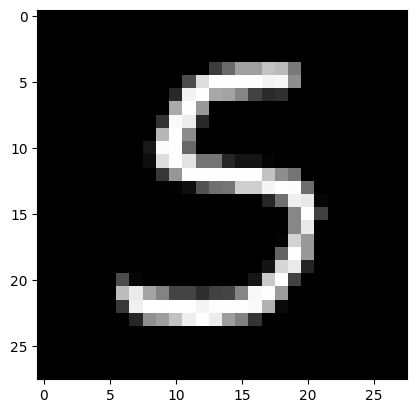

In [326]:
# 画像データを確認してみる
x, t = next(iter(train_dataloader))
image_sample1 = x[0,].view(28,28).detach().numpy()
plt.imshow(image_sample1, cmap="binary_r")

## GPUの使用

1. deviceを使用したいGPUに指定する
2. modelにデバイスを指定 model.to(device)
3. モデルで使用するデータにデバイス指定 x.to(device)

In [327]:
device = torch.device('mps')
print(device)


mps


モデル

In [328]:
model = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

モデルの学習と評価

In [330]:
loss_train_all = []
acc_train_all = []
loss_test_all = []
acc_test_all = []

for epoch in range(50):

    loss_train = 0
    acc_train = 0
    loss_test = 0
    acc_test = 0

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 全てのミニバッチ分の損失と正解率を足し合わせる
        loss_train += loss.item() #スカラーテンソルからスカラーチを取得する
        acc_train += (y.argmax(axis=1) == t).sum() / len(t) # 予測値とラベルが一致するものを1として足し合わせてその割合を求める
    
    #データ全ての損失と正解率の合計から、
    # ミニバッチに対する平均の損失と正解率を記録するために求める
    loss_train_mean = loss_train / len(train_dataloader)
    acc_train_mean = acc_train / len(train_dataloader)

    # testデータで損失と精度の記録をとる
    with torch.no_grad():
        for x, t in test_dataloader:
            x, t = x.to(device), t.to(device)
            y = model(x)
            loss = criterion(y, t)

            loss_test += loss.item() #スカラーテンソルからスカラー値を取得する
            acc_test += (y.argmax(axis=1) == t).sum() / len(t)

    loss_test_mean = loss_test / len(test_dataloader)
    acc_test_mean = acc_test / len(test_dataloader)

    loss_train_all.append(loss_train_mean)
    acc_train_all.append(acc_train_mean)
    loss_test_all.append(loss_test_mean)
    acc_test_all.append(acc_test_mean)


    if epoch % 10 == 0:
        print(f"Epoch:{epoch}")
        print(f"loss_train: {loss_train_mean :4f}, acc_train: {acc_train_mean: 4f}")
        print(f"loss_test: {loss_test_mean: 4f}, acc_test: {acc_test_mean: 4f}")


        

Epoch:0
loss_train: 1.522668, acc_train:  0.688899
loss_test:  0.816557, acc_test:  0.838600


KeyboardInterrupt: 

In [304]:
print(range(len(loss_train_all)))
print(range(50))
print(loss_train_all)
print(acc_train_all)
print(loss_test_all)
print(acc_test_all)

range(0, 50)
range(0, 50)
[0.3221683201317986, 0.3111695141593615, 0.3017116384456555, 0.29322841932376226, 0.2851305033390721, 0.27760868685940904, 0.27030090533196927, 0.263473832209905, 0.25673995112379394, 0.2504487417762478, 0.24448357538630566, 0.23837660862753787, 0.23286970478792984, 0.22729175778726737, 0.22228982545435427, 0.21726276174187661, 0.21253253340721132, 0.20812290796389182, 0.20369209934026003, 0.19952594216912986, 0.1956161075209578, 0.19159700066472093, 0.18791749027868113, 0.1843441088249286, 0.18071690388644734, 0.17729763515293598, 0.17411448750024042, 0.17086399164671698, 0.16783893919239443, 0.16506491062541803, 0.1621516634648045, 0.15934721631929277, 0.15657304982344308, 0.15408310652400056, 0.15160646178449194, 0.1491891249579688, 0.14680621637031435, 0.14438038990211985, 0.14226575195789337, 0.14012707215112943, 0.13792235693583885, 0.13587367337817946, 0.1338291336192439, 0.13195840334519743, 0.13003179718429844, 0.12817538574337958, 0.1263974617049098,

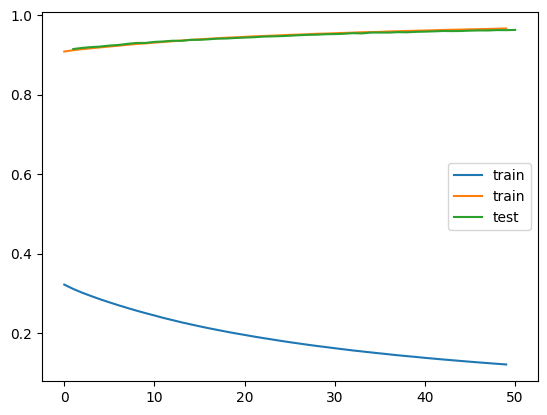

In [308]:
plt.plot(range(len(loss_train_all)), loss_train_all, label="train")
# plt.plot(range(1,len(loss_test_all)+1), loss_test_all, label="test")
plt.legend()


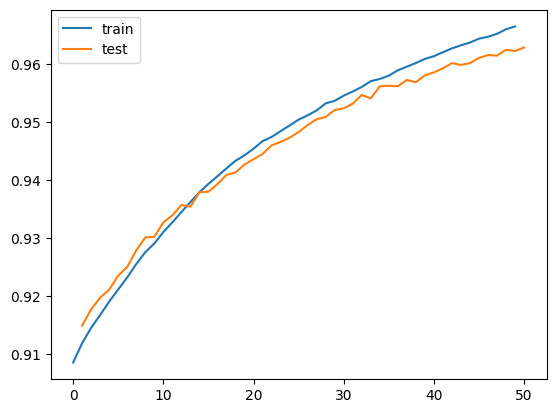

In [309]:
plt.plot(range(len(acc_train_all)), acc_train_all, label="train")
plt.plot(range(1,len(acc_test_all)+1), acc_test_all, label="test")
plt.legend()

-----

## クラスによるモデルの定義 + 正規化・Dropout

In [310]:
#クラスによるモデルの定義
# Sequentialよりモデルの定義に複雑さや柔軟性や使い回しが必要な場合に適している
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # インスタンス時に引数が必要ないものはforward内でインスタンス化する
        self.l1 = nn.Linear(784, 200)
        self.l2 = nn.Linear(200,10)
        self.dropout = nn.Dropout(0, 1)
        self.bnorm = nn.BatchNorm1d(200)
    # forward関数はmodelをそのまま関数として変数にインスタンス化して呼び出すことで使用することで自動実行される
    def forward(self, x): 

        x = self.l1(x)
        x = self.bnorm(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.l2(x)
        return x

In [311]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

学習と評価の変更点

In [ ]:
# Dropoutや正規化をしている場合には、学習時と評価時には挙動が異なるため、モードを変更する必要がある
# dropoutは評価時には行われないなど

loss_train_all = []
acc_train_all = []
loss_test_all = []
acc_test_all = []

for epoch in range(50):

    loss_train = 0
    acc_train = 0
    loss_test = 0
    acc_test = 0

    # 学習モードとして学習
    model.train()
    for (x, t) in train_dataloader:
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        acc_train += (y.argmax(axis=1) == t).sum() / len(t) 
    
    loss_train_mean = loss_train / len(train_dataloader)
    acc_train_mean = acc_train / len(train_dataloader)

    # 評価モードとして予測
    model.eval()
    with torch.no_grad():
        for x, t in test_dataloader:
            y = model(x)
            loss = criterion(y, t)

            loss_test += loss.item()
            acc_test += (y.argmax(axis=1) == t).sum() / len(t)

    loss_test_mean = loss_test / len(test_dataloader)
    acc_test_mean = acc_test / len(test_dataloader)

    loss_train_all.append(loss_train_mean)
    acc_train_all.append(acc_train_mean)
    loss_test_all.append(loss_test_mean)
    acc_test_all.append(acc_test_mean)


    if epoch % 10 == 0:
        print(f"Epoch:{epoch}")
        print(f"loss_train: {loss_train_mean :4f}, acc_train: {acc_train_mean: 4f}")
        print(f"loss_test: {loss_test_mean: 4f}, acc_test: {acc_test_mean: 4f}")


        

### CNNの簡単な実装例

In [315]:
# 畳込みなどの層内で複数のlayerによって計算を行う場合にはforward関数内でネストして層単位で形式化できる
def foward(self, x):
    x = torch.relu(nn.BatchNorm2d(nn.Conv2d(x)))
    x = F.max_pool2d(torch.relu(nn.BatchNorm2d(nn.Conv2d(x))), 2)
    x = x.view(-1, 576) # 畳み込みで特徴を抽出したら、ベクトルに変換する
    x = torch.relu(nn.BatchNorm1d(nn.Linear(x)))
    x = nn.Linear(128, 10)(x)
    return x

-----

----

#### tensor.detach()
テンソルから計算グラフを切り離し、勾配情報がない状態のテンソルを得ることができる

### nn.Linear()

In [117]:
m = nn.Linear(20, 30) # in_feature:入力要素数 / out_feature:出力要素数
# 重みのサイズは(out_f x in_f)となる => wxの計算の出力サイズが(out_f, 1)になるように
input = torch.randn(128, 20) # １arg:バッチ数 / 2arg:入力要素数
output = m(input)
print(output.size())

torch.Size([128, 30])
